In [24]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [27]:
def load_from_filenames(folder_path, img_size=64):
    features_list = []
    labels_list = []

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    # Lista tutti i file nella cartella
    all_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    for filename in tqdm(all_files, desc="Elaborazione immagini"):
        # 1. Estrazione Label: prendiamo tutto ciò che sta prima del primo '_'
        # Esempio: "background_a_1.png" -> "background"
        # Esempio: "a_v1.png" -> "a"
        label = filename.split('_')[0]
        
        # 2. Caricamento e Preprocessing
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            continue
            
        img = cv2.resize(img, (img_size, img_size))
        feat = clahe.apply(img) # Bilancia l'esposizione
        feat = hog(feat, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)
        
        features_list.append(feat.flatten())
        labels_list.append(label)
        
    return np.array(features_list), np.array(labels_list)

X, y = load_from_filenames("/home/mattia/Desktop/unige/ml2/machineLearning2_Assignment/training-a-robot-to-understand-sign-language/signlanguage/signlanguage")

Elaborazione immagini: 100%|██████████| 8492/8492 [00:10<00:00, 809.68it/s]


Elaborazione: 100%|██████████| 8492/8492 [00:33<00:00, 253.77it/s]


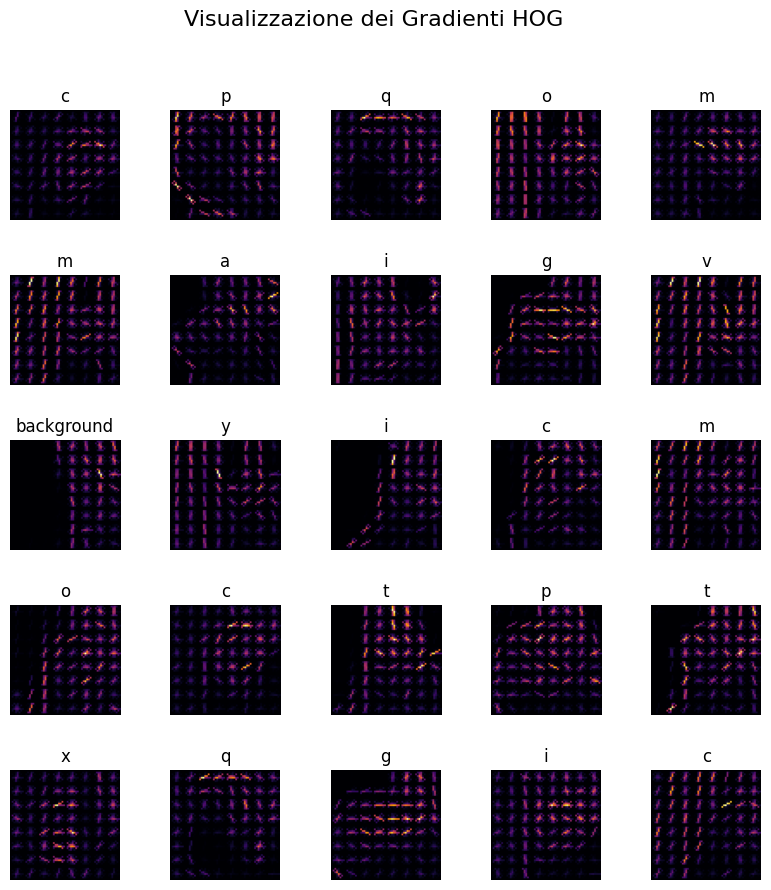

In [30]:
from skimage.feature import hog

def load_with_hog_viz(folder_path, img_size=64, n_to_show=25):
    features_list = []
    labels_list = []
    hog_images = [] # Qui salviamo le immagini HOG da plottare

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    all_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    for i, filename in enumerate(tqdm(all_files, desc="Elaborazione")):
        label = filename.split('_')[0]
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
            
        img_res = cv2.resize(img, (img_size, img_size))
        img_eq = clahe.apply(img_res)
        
        # Estrazione HOG con visualizzazione
        # fd è il vettore delle feature (1764 elementi)
        # hog_image è l'immagine 64x64 dei gradienti
        fd, hog_image = hog(img_eq, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True)
        
        features_list.append(fd)
        labels_list.append(label)
        
        if i < n_to_show:
            hog_images.append(hog_image)
        
    return np.array(features_list), np.array(labels_list), hog_images

# Carichiamo i dati
X, y, imgs_hog = load_with_hog_viz("/home/mattia/Desktop/unige/ml2/machineLearning2_Assignment/training-a-robot-to-understand-sign-language/signlanguage/signlanguage")

# --- PLOT DELL'HOG ---
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
for i, ax in enumerate(axs.reshape(-1)):
    # L'immagine HOG è già 64x64, non serve reshape
    ax.imshow(imgs_hog[i], cmap='inferno') # 'inferno' o 'gray' rendono bene l'idea dei gradienti
    ax.axis('off')
    ax.set_title(str(y[i]))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Visualizzazione dei Gradienti HOG", fontsize=16)
plt.show()

(8476, 1764)
(8476,)


ValueError: cannot reshape array of size 1764 into shape (64,64)

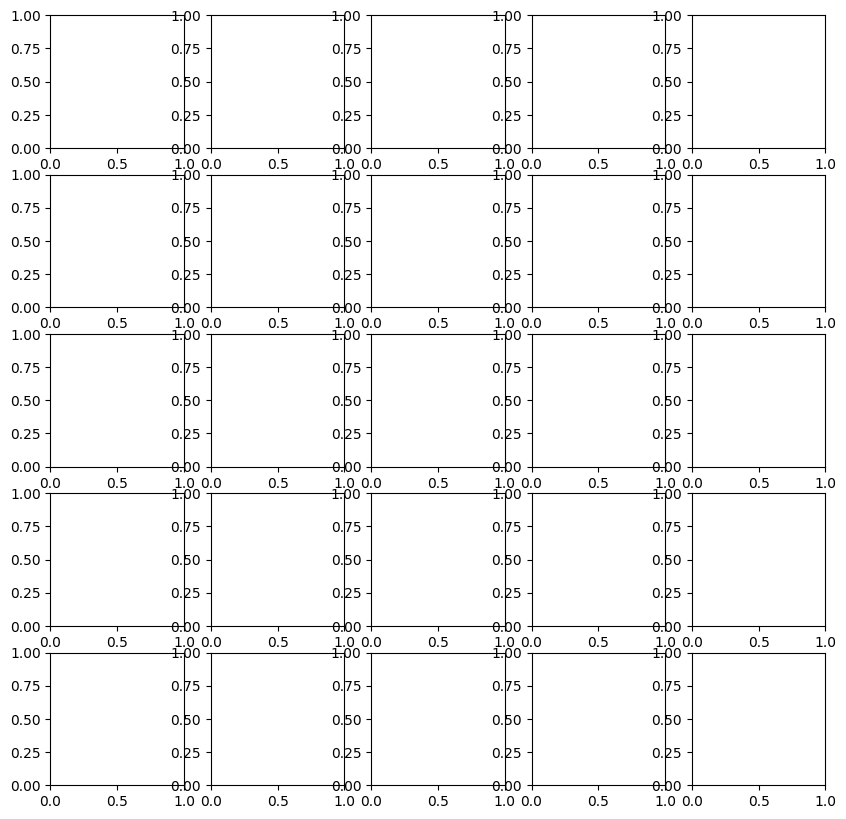

In [28]:
# Utilizzo:
print(X.shape)
print(y.shape)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10,10))
i = 0
for ax in axs.reshape(-1):
  s = X[i,:]
  l = y[i]
  imm = np.reshape(s,(64,64))
  ax.imshow(imm, cmap='gray')
  ax.axis('off')
  ax.set_title(str(l))
  i = i + 1
plt.subplots_adjust(hspace=1)
plt.show()

for i in np.unique(y):
  print('y = ' + str(i) + ': ' + str(np.sum(y==i)))

In [17]:

Xl, Xt, yl, yt = train_test_split(X, y, test_size=0.75, random_state=11)

grid = {'C':                       np.logspace(-6,3,10),
        'kernel':                  ['linear'],
        'decision_function_shape': ['ovr']}
M = GridSearchCV(estimator  = SVC(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'accuracy',
                 n_jobs= 20)
M.fit(Xl, yl)
yp = M.predict(Xt)
perr = 100*np.mean(yp != yt)
print('%Err: ' +  str(perr))
print('%CM:\n ' +  str(confusion_matrix(yt,yp)))

%Err: 6.386660374390436
%CM:
 [[256   0   0   0   0   0   0   0   0   3   1   0   3   8   0   0   0   0
    6   0   0   0   0   0   0]
 [  0 345   3   0   0   6   3   0   0   0   9   0   0   0   0   0   0   0
    2   0   0   0   2   0   0]
 [  0   0 355   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0   0   0 273   0   0   1   0   0   0   0   0   0   0   3   0   0   0
    1   0   0   0   1   0   0]
 [  1   0   0   0 195   0   1   0   0   6   0   0   5   3   0   0   0   0
    0   0   3   0   0   1   0]
 [  2   0   0   0   0 190   0   0   0   0   0   0   1   0   4   0   0   0
    1   0   0   0   0   0   0]
 [  1   2   0   0   0   0 235   0   0   2   0   0   0   0   0   0   0   0
    0   0   0   2   3   0   1]
 [  0   0   0   0   0   0   0 217   1   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0  10 254   0   0   0   0   2   0   7   0   0
    0   0   0   0   0   0   0]
 [  6   2   0   0   7   0

In [48]:
grid = {'C':                       np.logspace(-6,3,10),
        'kernel':                  ['rbf'],
        'gamma':                   np.logspace(-6,3,10),
        'decision_function_shape': ['ovr']}
M = GridSearchCV(estimator  = SVC(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'accuracy')
M.fit(Xl, yl)
yp = M.predict(Xt)
perr = 100*np.mean(yp != yt)
print('%Err: ' +  str(perr))
print('%CM:\n ' +  str(confusion_matrix(yt,yp)))

KeyboardInterrupt: 

In [19]:
from sklearn.model_selection import train_test_split
Y = y
X,  _ , Y,  _  = train_test_split(X, Y, train_size=5000, random_state=0)
X, XT , Y, YT  = train_test_split(X, Y, train_size= 300, random_state=0)

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.tree import plot_tree
def quality(M,XT,YT):
  Yp = M.predict(XT)
  print('ACC: ' + format(accuracy_score(YT,Yp),".3f"))
  print('BAC: ' + format(balanced_accuracy_score(YT,Yp),".3f"))
  print('CM: \n' + str(confusion_matrix(YT,Yp)))

/home/mattia/Desktop/unige/ml2/machineLearning2_Assignment/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


max_depth best: 30
ACC: 0.302
BAC: 0.294
CM: 
[[ 42  14   2   4   3   4   6   6   7   6   9   1  40  27   0   0   4   0
    9   5   1   3   2   1   6]
 [  9  85   3   1   5  17  16   4   0   5  23   3   1   2  26   6   7   4
    7   8   8  13  11   7   7]
 [  0   2 134   0   3   4   1   0   1   2   9   0   0   1   8  16   1  43
    3   0  18   3   2   2   0]
 [ 16  16   2  88   3   9   1   8   3   6   3   1   0   2  18   1   1   3
    5   4   1   7  10   7   7]
 [  0  18   0   3  22  10   7   5   0   4  10   3  10   3   5   3   8   6
    3   2   8   3  10   6  21]
 [  2   7   2  14  10  32   0   0   1   8  15   2   1   7  12   5   1  15
    0   2   3   1   2   3   1]
 [  1  22   5   1   6  32  38   0   0  10  15   1   0   2   1   7   0   8
   15   0   2   9   9   3   3]
 [  8   1   0   8   1   0   5  10  51   0   3   2   2   9   0  18   7   0
   16   0   1  29   0   4   0]
 [  1   0   2   5   0   0   7   3 125   0   0   0   2   2   0  10  13   2
    1   0   0   5   1   1   2]
 [  5  19

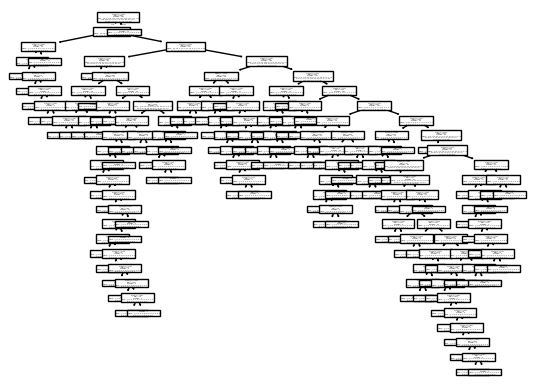

In [23]:
from sklearn.tree import DecisionTreeClassifier
grid = {'max_depth': [2,4,6,8,12,16,20,30]}
M = GridSearchCV(estimator  = DecisionTreeClassifier(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'accuracy')
M.fit(X,Y)
print('max_depth best: ' + str(M.best_params_['max_depth']))
plot_tree(M.best_estimator_)
quality(M,XT,YT)

min_samples_leaf best: 8
ACC: 0.251
BAC: 0.234
CM: 
[[ 67  18   2   9   6   1   5   0  11   0   2   0  21  19   1   0   7   0
    0  21   2   0   6   4   0]
 [ 12  95   3   3  30   6   3   0   4   8  17   0   9   0  30   2  13   2
    0   9   9   2   5  16   0]
 [  1  46 116   0   8   0  15   0  13   2   2   0   1   0  25   1   3   0
    0   0  11   0   5   4   0]
 [  4  19   2  90  10   6   0   0   3   0   2   0   1   1   3   2   4   3
    0   3   0  23   7  39   0]
 [  1  21   0   8  27   9   7   0   0   6   5   0   9   4  11   3  14   4
    0   0  15   9   2  15   0]
 [  2   7   2  14  21  16   7   0   1   0  12   0   8   4   4   0   7  15
    0   0   2  12   7   5   0]
 [ 45  23   0   2  19  13   4   0   4   0   2   0   0   0  13   5   0   0
    0   0  28   0   2  30   0]
 [ 11   0   0  33  11   0   7   0  96   2   4   0   3   0   4   1   0   0
    0   3   0   0   0   0   0]
 [  5   0   0   7   2   2   3   0 149   0   2   0   0   0   5   1   0   2
    0   1   2   0   1   0   0]
 [ 

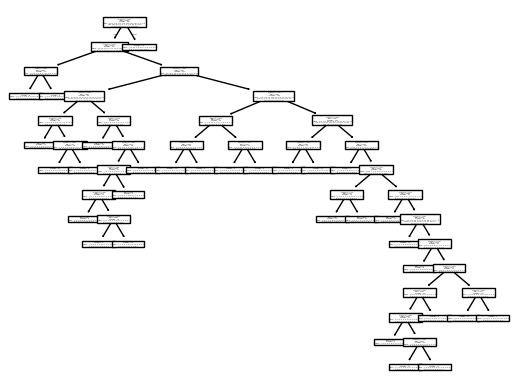

In [53]:
from sklearn.tree import DecisionTreeClassifier
grid = {'min_samples_leaf': [2,4,6,8,12,16,20,30]}
M = GridSearchCV(estimator  = DecisionTreeClassifier(),
                 param_grid = grid,
                 cv         = 3,
                 scoring    = 'accuracy')
M.fit(X,Y)
print('min_samples_leaf best: ' + str(M.best_params_['min_samples_leaf']))
plot_tree(M.best_estimator_)
quality(M,XT,YT)

In [54]:
from sklearn.ensemble import RandomForestClassifier
M = RandomForestClassifier(n_estimators=300)
M.fit(X,Y)
quality(M,XT,YT)

ACC: 0.599
BAC: 0.594
CM: 
[[114  11   2   0   0   0   1   0   3   0   2   0  51   0   0   1   1   8
    1   0   1   0   0   0   6]
 [ 16 161   6  14   0   1   7   0   0  14  24   0   2   0   3   0   0   9
    0   5   3   5   8   0   0]
 [  0   3 179   0   0   2   0   0   0   0   8   0   0   0   0   0   0  14
    0   0   0  47   0   0   0]
 [  3  17   3 139   6   2   2   0   0   1   1   0   7   9  29   1   0   0
    1   1   0   0   0   0   0]
 [  2   3   0  14  92   7   0   0   0   9   1   0  12   3  13   0   0   2
    0   0   0   0   0  12   0]
 [  0  21   0  19   0  66   1   0   0   0   3   0   9  11  10   1   2   0
    0   3   0   0   0   0   0]
 [  6  39   0  33   0   0  72   0   1  13   5   0   1   2   9   0   1   0
    0   0   1   3   4   0   0]
 [  3   0   0   3   0   0   0  15 137   0   0   0   2   0   0   5   0   0
    0  10   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 182   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  3  20   0   0   2   2   

In [22]:
from sklearn.ensemble import RandomForestClassifier
grid = {'n_estimators': [300],
        'max_features': [10,16,20,28,32,40]}
M = GridSearchCV(estimator  = RandomForestClassifier(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'accuracy')
M.fit(X,Y)
print('n_estimators best: ' + str(M.best_params_['n_estimators']))
print('max_features best: ' + str(M.best_params_['max_features']))
quality(M,XT,YT)

/home/mattia/Desktop/unige/ml2/machineLearning2_Assignment/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:813: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


n_estimators best: 300
max_features best: 20
ACC: 0.592
BAC: 0.588
CM: 
[[122  11   2   1   0   1   2   0   2   0   2   0  27   2   1   0   4  13
    0   4   0   0   0   0   8]
 [ 24 154   7  13   2   0  12   0   0   5  23   0   2   1   5   0   0  14
    0   4   1   4   5   1   1]
 [  3   0 164   0   0   2   0   0   0   0  11   0   0   0   0   0   0  26
    0   0   0  47   0   0   0]
 [  5  18   1 134   7   2   0   0   0   2   0   0  14   8  28   1   0   0
    0   2   0   0   0   0   0]
 [  2   7   0  15  90   2   1   0   1   9   1   0  17   0   6   0   1   5
    0   1   0   0   0  12   0]
 [  1  26   0  13   0  58   0   0   0   0   3   0  17  13   8   0   0   4
    0   3   0   0   0   0   0]
 [ 10  40   0  33   0   1  71   0   0   9   5   0   0   0   8   0   0   1
    0   0   3   3   1   2   3]
 [  7   0   0   0   0   0   0  16 133   0   0   0   2   0   0   7   0   0
    4   6   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 182   0   0   0   0   0   0   0   0   0
    0   0   0 

In [58]:
from sklearn.ensemble import GradientBoostingClassifier
grid = {'n_estimators':  [10],
        'learning_rate': [0.001, 0.005, .01, 0.05, .1]}
M = GridSearchCV(estimator  = GradientBoostingClassifier(),
                 param_grid = grid,
                 cv         = 3,
                 scoring    = 'accuracy')
M.fit(X,Y)
print('n_estimators best:  ' + str(M.best_params_['n_estimators']))
print('learning_rate best: ' + str(M.best_params_['learning_rate']))
quality(M,XT,YT)

KeyboardInterrupt: 

In [56]:
from sklearn.neighbors import KNeighborsClassifier
grid = {'n_neighbors':  [1,3,5,7,9,11,15,19]}
M = GridSearchCV(estimator  = KNeighborsClassifier(),
                 param_grid = grid,
                 cv         = 3,
                 scoring    = 'accuracy')
M.fit(X,Y)
print('n_neighbors best: ' + str(M.best_params_['n_neighbors']))
quality(M,XT,YT)

n_neighbors best: 1
ACC: 0.621
BAC: 0.627
CM: 
[[127  20   4   2   0   6   0   0   0   0   1   0  18  13   0   0   0   0
    1   0   4   0   0   0   6]
 [ 12 162   3   7   0  18   2   0   0   1  10   0   9  11   4   0   0   8
    2  12   6   3   3   3   2]
 [  0  21 156   0   0   0   0   0   0   2  10   2   0   0   0   0   0  50
    1   0   0   7   4   0   0]
 [  3   1   1 118   1   6   2   0   0   1   3   1  16  27  30   0   0   1
    0   0   4   1   1   3   2]
 [  2   2   4   5  99   1   2   0   0  13   2   0   7   3   1   0   0  13
    0   0   1   1   0  11   3]
 [  0   9   5  11   0  77   4   0   0   0  19   0   4   7   0   0   0   0
    3   0   5   1   0   0   1]
 [  0  19   4  16   1  19  80   0   0   5   4   0   2   6   1   0   0   0
    0   0  10  12   1   5   5]
 [  0   0   7   5   0   0   0  67  69   4   0   1  14   0   0   0   0   0
    4   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0 181   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0  1